# Import libraries

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Colab Notebooks/TX

Mounted at /gdrive
/gdrive/My Drive/Colab Notebooks/TX


In [ ]:
import cv2
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from tqdm import tqdm

import torch
from torch.nn import functional as F
from skimage import transform, measure
from PIL import Image
import torchvision.transforms as transforms

# Functions

In [ ]:
def load_images_to_array_tif(folder_path):
    """
    Load all TIF images (including multi-page TIFs) from the specified folders into a NumPy array.
    Each page of a multi-page TIF will be loaded as a separate image.

    Args:
        folder_path: Path to the root folder.

    Returns:
        images: List of uploaded images (NumPy arrays).
        paths: List of paths to original files, with frame index for multi-page TIFs (e.g., 'path/to/image.tif#0').
    """

    images = []
    paths = []

    base_folders = []
    # Iterate through items in the root folder to find the desired base folders
    for item in os.listdir(folder_path):
        item_path = os.path.join(folder_path, item)
        # Check if the item is a directory and matches the naming convention "v * cm_s"
        if os.path.isdir(item_path) and item.startswith("v ") and item.endswith(" cm_s"):
            base_folders.append(item_path)

    # If no folders are found, print a message and return empty lists
    if not base_folders:
        print("No folders found matching the pattern 'v * cm_s'.")
        return images, paths

    print(f"Found {len(base_folders)} folders:")
    for folder in base_folders:
        print(f"- {os.path.basename(folder)}")

    # Process each identified base folder
    for base_folder in base_folders:
        print(f"Scanning the folder: {os.path.basename(base_folder)}")

        # Find all .tif files recursively within the base folder
        tif_files = glob.glob(os.path.join(base_folder, '**', '*.tif'), recursive=True)

        # Use tqdm for a progress bar while loading images
        for tif_file in tqdm(tif_files, desc=f"Loading images from {os.path.basename(base_folder)}"):
            try:
                # Open the TIFF file using Pillow
                with Image.open(tif_file) as img_pil:
                    # Check if it's a multi-page TIFF
                    if hasattr(img_pil, 'n_frames') and img_pil.n_frames > 1:
                        # Iterate through each frame (page)
                        for page_idx in range(img_pil.n_frames):
                            img_pil.seek(page_idx)
                            # Convert PIL Image to NumPy array (RGB format directly from Pillow)
                            img_np = np.array(img_pil.convert('RGB'))

                            images.append(img_np)
                            # Store the original path with a frame index to identify each unique image
                            paths.append(f"{tif_file}#{page_idx}")
                    else:
                        # Handle single-page TIFFs
                        img_np = np.array(img_pil.convert('RGB'))
                        images.append(img_np)
                        paths.append(tif_file) # No frame index needed for single page

            except Exception as e:
                print(f"Warning: Could not load TIF file {tif_file}. Error: {e}")

    print(f"Completed! Loaded {len(images)} images in total.")

    return images, paths

# Function to visualize images
def show_sample_images(images, labels, categories, num_samples=5):
    """
    View some sample images by category

    Args:
        images: List of images
        labels: List of labels
        categories: List of categories
        num_samples: Number of samples to display per category
    """

    if not images:
        print("No images to visualized")
        return

    fig, axes = plt.subplots(len(categories), num_samples, figsize=(15, 3*len(categories)))

    for cat_idx, category in enumerate(categories):
        cat_indices = [i for i, label in enumerate(labels) if label == cat_idx]

        samples = min(num_samples, len(cat_indices))

        for sample_idx in range(samples):
            if len(categories) > 1:
                ax = axes[cat_idx, sample_idx]
            else:
                ax = axes[sample_idx]

            img_idx = cat_indices[sample_idx]

            ax.imshow(images[img_idx])
            ax.set_title(f"{category}")
            ax.axis('off')

        for j in range(samples, num_samples):
            if len(categories) > 1:
                axes[cat_idx, j].axis('off')
            else:
                axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Function to convert list into NumPy
def convert_to_numpy_arrays(images, labels):
    """
    Converts lists of images and labels to NumPy arrays

    Args:
        images: List of images
        labels: List of labels

    Returns:
        X: NumPy array containing all images
        y: Array NumPy containing all labels
    """

    if images:
        heights = [img.shape[0] for img in images]
        widths = [img.shape[1] for img in images]
        channels = [img.shape[2] for img in images]

        if len(set(heights)) > 1 or len(set(widths)) > 1 or len(set(channels)) > 1:
            print("WARNING: Images have different sizes!")
            print(f"Height: {set(heights)}")
            print(f"Width: {set(widths)}")
            print(f"Channel: {set(channels)}")

            from collections import Counter
            common_height = Counter(heights).most_common(1)[0][0]
            common_width = Counter(widths).most_common(1)[0][0]
            common_channels = Counter(channels).most_common(1)[0][0]

            print(f"Resizing all images to {common_height}x{common_width}x{common_channels}")

            resized_images = []
            for img in tqdm(images, desc="Image resizing"):
                if img.shape != (common_height, common_width, common_channels):
                    resized = cv2.resize(img, (common_width, common_height))
                    resized_images.append(resized)
                else:
                    resized_images.append(img)

            X = np.stack(resized_images, axis=0)
        else:
            X = np.stack(images, axis=0)
    else:
        X = np.array([])

    y = np.array(labels)

    return X, y


In [ ]:
def load_pretrained_unet(scale=0.5):
    """
    Load the pretrained PyTorch U-Net model from torch.hub
    """
    print("Loading pretrained U-Net model from torch.hub...")
    try:
        model = torch.hub.load('milesial/Pytorch-UNet', 'unet_carvana', pretrained=True, scale=scale)
        model.eval()
        if torch.cuda.is_available():
            model = model.cuda()
            print("Model loaded on GPU")
        else:
            print("Model loaded on CPU")
        return model

    except Exception as e:
        print(f"Error loading pretrained U-Net model: {e}")
        return None

def preprocess_for_pytorch(images, target_size):
    """
    Preprocess images for the PyTorch U-Net model
    """
    processed_tensors = []
    original_sizes = []

    # Define the preprocessing transform
    preprocess = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor()
        #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    for img in images:
        # Store original size for later
        original_sizes.append((img.shape[0], img.shape[1]))

        # Convert to PIL Image for PyTorch transforms
        pil_img = Image.fromarray(np.uint8(img * 255) if img.max() <= 1.0 else np.uint8(img))

        # Apply preprocessing
        tensor = preprocess(pil_img)
        processed_tensors.append(tensor)

    return processed_tensors, original_sizes

def segment_with_pytorch_unet(model, images, target_size, batch_size=4):
    """
    Segment cells using the pretrained PyTorch U-Net model
    """
    print("Segmenting cells with PyTorch U-Net...")
    processed_tensors, original_sizes = preprocess_for_pytorch(images, target_size)

    masks = []

    # Process in batches
    with torch.no_grad():
        for i in range(0, len(processed_tensors), batch_size):
            batch = processed_tensors[i:i+batch_size]
            batch_tensor = torch.stack(batch)

            # Move to GPU if available
            if torch.cuda.is_available():
                batch_tensor = batch_tensor.cuda()

            # Predict masks
            outputs = model(batch_tensor)

            # Apply sigmoid to get probability masks
            probs = torch.sigmoid(outputs)

            # Move back to CPU and convert to numpy
            probs = probs.cpu().numpy()

            # Add to results
            for j in range(probs.shape[0]):
                mask = probs[j, 0]  # Get the first (and only) channel
                masks.append(mask)

    return np.array(masks)

def extract_and_crop_cells(images, labels, masks, margin=3, threshold=0.5):
    """
    Extract cells and crop them with a margin around each cell
    """
    print("Extracting and cropping cells...")
    cropped_cells = []
    cell_metadata = []
    binary_masks = []
    num_labels = []
    num_real_cells = []

    for idx, (img, mask) in enumerate(zip(images, masks)):
        lab_idx = labels[idx]
        # Apply threshold to get binary mask
        binary_mask = (mask < threshold).astype(np.uint8)

        # Remove small objects and fill holes for better segmentation
        binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8))
        binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8))

        binary_masks.append(binary_mask)

        # Find connected components
        labeled_mask, num_label = measure.label(binary_mask, return_num=True, connectivity=2)

        if num_label == 0:
            print(f"No cells detected in image {idx}")
            continue
        num_labels.append(num_label)

        print(f"Found {num_label} cells in image {idx}")
        num_real_cell = 0

        # Process each detected cell
        for label_idx in range(1, num_label + 1):
            # Extract single cell mask
            cell_mask = (labeled_mask == label_idx).astype(np.uint8)

            # Find cell properties
            props = measure.regionprops(cell_mask)
            if not props:
                continue

            # Get cell bounding box
            min_row, min_col, max_row, max_col = props[0].bbox

            # Check if the cell is too small (might be noise)
            cell_height = max_row - min_row
            cell_width = max_col - min_col

            if cell_height < 5 or cell_width < 5:
                continue  # Skip very small regions

            if cell_width > 60:
                continue  # Skip very large regions

            # Calculate radius of the cell (approximating as a circle)
            # Using the maximum of height/2 and width/2 to ensure we encompass the entire cell
            radius = max(cell_height, cell_width) / 2

            # Get the cell center coordinates
            center_row = (min_row + max_row) // 2
            center_col = (min_col + max_col) // 2

            # Calculate cropping boundaries with margin around the cell
            crop_min_row = max(0, center_row - radius - margin)
            crop_max_row = min(img.shape[0], center_row + radius + margin)
            crop_min_col = max(0, center_col - radius - margin)
            crop_max_col = min(img.shape[1], center_col + radius + margin)

            # Convert to integers
            crop_min_row, crop_max_row = int(crop_min_row), int(crop_max_row)
            crop_min_col, crop_max_col = int(crop_min_col), int(crop_max_col)

            # Crop the cell from original image
            cropped_cell = img[crop_min_row:crop_max_row, crop_min_col:crop_max_col].copy()

            # Make sure we actually have a cell to save
            if cropped_cell.size == 0 or cropped_cell.shape[0] == 0 or cropped_cell.shape[1] == 0:
                continue

            # Count real cells
            if cropped_cell.max() > 1:
                num_real_cell = num_real_cell + 1

            # Add to results
            cropped_cells.append(cropped_cell)

            # Store metadata about this cell
            cell_metadata.append({
                'original_image_idx': idx,
                'cell_idx': lab_idx,
                'center': (center_row, center_col),
                'radius': radius,
                'crop_coords': (crop_min_row, crop_min_col, crop_max_row, crop_max_col),
                'height': crop_max_row - crop_min_row,
                'width': crop_max_col - crop_min_col,
                'area': props[0].area
            })

        print(f"{num_real_cell} real cells found in image {idx}")
        num_real_cells.append(num_real_cell)

    return cropped_cells, cell_metadata, binary_masks, num_labels, num_real_cells

def visualize_results(original_images, masks, cropped_cells, cell_metadata, num_samples=3):
    """
    Visualize segmentation and cell extraction results
    """
    num_samples = min(num_samples, len(original_images))

    plt.figure(figsize=(15, 5 * num_samples))

    for i in range(num_samples):
        # Original image
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(original_images[i], cmap = 'gray')
        plt.title('Mask')
        plt.axis('off')

        # Mask
        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(masks[i], cmap='gray')
        plt.title('Binary Mask')
        plt.axis('off')

        # If we have cropped cells, show the first one from this image
        cell_indices = [j for j, m in enumerate(cell_metadata) if m['original_image_idx'] == i]

        if cell_indices:
            plt.subplot(num_samples, 3, i*3 + 3)
            plt.imshow(cropped_cells[cell_indices[0]])
            plt.title(f'Cropped Cell (r={cell_metadata[cell_indices[0]]["radius"]:.1f}px)')
            plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Also show a grid of cropped cells if we have many
    # if len(cropped_cells) > 9:
    #     plt.figure(figsize=(12, 12))
    #     for i in range(min(9, len(cropped_cells))):
    #         plt.subplot(3, 3, i+1)
    #         plt.imshow(cropped_cells[i])
    #         meta = cell_metadata[i]
    #         plt.title(f'Cell {i} ({meta["width"]}x{meta["height"]}px)')
    #         plt.axis('off')
    #     plt.tight_layout()
    #     plt.show()

def save_cropped_cells(cropped_cells, output_dir, original_labels=None, cell_metadata=None):
    """
    Save the cropped cells as images
    """
    if len(cropped_cells) == 0:
        print("No cropped cells to save.")
        return

    os.makedirs(output_dir, exist_ok=True)

    # Create subdirectories for each category if labels are provided
    if original_labels is not None:
        label_dirs = {}
        unique_labels = np.unique(original_labels)
        for label in unique_labels:
            label_dir = os.path.join(output_dir, f"class_{label}")
            os.makedirs(label_dir, exist_ok=True)
            label_dirs[label] = label_dir

    # Save each cropped cell
    for i, cell_img in enumerate(cropped_cells):
        if cell_metadata and i < len(cell_metadata):
            metadata = cell_metadata[i]
            original_idx = metadata['original_image_idx']

            # Determine the label for this cell
            if original_labels is not None and original_idx < len(original_labels):
                label = original_labels[original_idx]
                save_path = os.path.join(label_dirs[label], f"cell_{original_idx}_{metadata['cell_idx']}.png")
            else:
                save_path = os.path.join(output_dir, f"cell_{i}.png")
        else:
            save_path = os.path.join(output_dir, f"cell_{i}.png")

        # Convert to uint8 for saving
        if cell_img.dtype == np.float32 or cell_img.dtype == np.float64:
            if cell_img.max() <= 1.0:
                cell_img_uint8 = (cell_img * 255).astype(np.uint8)
            else:
                cell_img_uint8 = cell_img.astype(np.uint8)
        else:
            cell_img_uint8 = cell_img

        # Save the image
        plt.imsave(save_path, cell_img_uint8)

    print(f"Saved {len(cropped_cells)} cropped cells to {output_dir}")

def process_cell_images_with_pytorch_unet(images, labels, target_size, scale, margin):
    """
    Main function to process cell images using the pretrained PyTorch U-Net model
    """
    # Step 1: Load pretrained PyTorch U-Net model
    model = load_pretrained_unet(scale=scale)
    #
    if model is None:
        print("Failed to load pretrained model. Exiting.")
        return None, None, None

    # Step 2: Segment cells with the model
    masks = segment_with_pytorch_unet(model, images, target_size)

    # Step 3: Extract and crop cells (with margin)
    cropped_cells, cell_metadata, binary_masks, num_fake_cells, num_real_cells = extract_and_crop_cells(images, labels, masks, margin=margin, threshold= 0.8)

    # Step 4: Visualize results
    visualize_results(masks, binary_masks, cropped_cells, cell_metadata)

    # Step 5: Save cropped cells
    output_dir = "./cropped_cells_2024"
    save_cropped_cells(cropped_cells, output_dir, labels, cell_metadata)

    return cropped_cells, cell_metadata, masks, num_fake_cells, num_real_cells


# 2024 study dataset

In [ ]:
folder_path_german = "/gdrive/My Drive/Colab Notebooks/TX/Dataset_original/RBC seq for Badr Kaoui/RBC seq for Badr Kaoui"
categories_german = ['NotDefined']

# Load images
images_german, paths_german = load_images_to_array_tif(folder_path_german)
images, labels = convert_to_numpy_arrays(images_german, categories_german)


Found 8 folders:
- v 1.25 cm_s
- v 1 cm_s
- v 0.9 cm_s
- v 1.56 cm_s
- v 0.56 cm_s
- v 0.12 cm_s
- v 0.44 cm_s
- v 0.7 cm_s
Scanning the folder: v 1.25 cm_s


Loading images from v 1.25 cm_s: 100%|██████████| 157/157 [00:26<00:00,  5.98it/s]


Scanning the folder: v 1 cm_s


Loading images from v 1 cm_s: 100%|██████████| 48/48 [00:30<00:00,  1.55it/s]


Scanning the folder: v 0.9 cm_s


Loading images from v 0.9 cm_s: 100%|██████████| 73/73 [00:40<00:00,  1.82it/s]


Scanning the folder: v 1.56 cm_s


Loading images from v 1.56 cm_s: 100%|██████████| 300/300 [00:15<00:00, 18.81it/s]


Scanning the folder: v 0.56 cm_s


Loading images from v 0.56 cm_s: 100%|██████████| 268/268 [00:14<00:00, 18.77it/s]


Scanning the folder: v 0.12 cm_s


Loading images from v 0.12 cm_s: 100%|██████████| 79/79 [00:42<00:00,  1.87it/s]


Scanning the folder: v 0.44 cm_s


Loading images from v 0.44 cm_s: 100%|██████████| 210/210 [00:12<00:00, 16.57it/s]


Scanning the folder: v 0.7 cm_s


Loading images from v 0.7 cm_s: 100%|██████████| 248/248 [00:14<00:00, 17.28it/s]


Completed! Loaded 18498 images in total.


In [ ]:
first_image = images[0]

if len(first_image.shape) == 2:
    print("The image is Grayscale (single channel).")
elif len(first_image.shape) == 3 and first_image.shape[2] == 1:
    print("The image is Grayscale but stored with an extra dimension.")
elif len(first_image.shape) == 3 and first_image.shape[2] == 3:
    print("The image is RGB (three channels).")
else:
    print("Unknown format:", first_image.shape)

first_image.shape

The image is RGB (three channels).


(128, 672, 3)

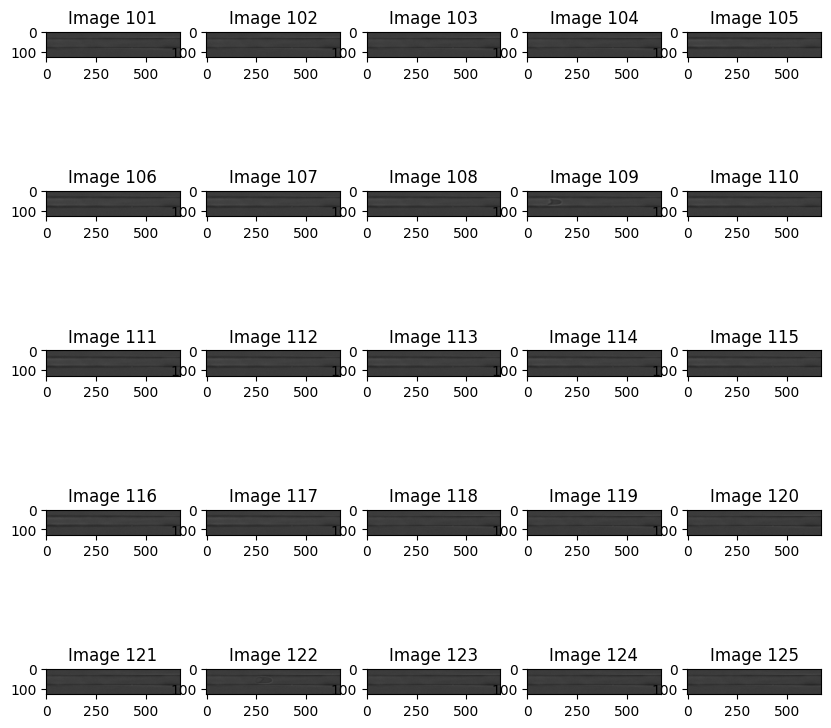

In [ ]:
# Show a range of images
img=100
plt.figure(figsize=(10, 10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.imshow(images[i+img])
  plt.title(f'Image {i+img+1}')
plt.show()

## Detect cell

In [ ]:
if len(images) > 0:
    MARGIN = 20
    # Process images with pretrained PyTorch U-Net
    cropped_cells, cell_metadata, masks, num_fake_cells, num_real_cells = process_cell_images_with_pytorch_unet(
        images, labels, target_size=(128, 672), scale=0.5, margin=MARGIN
    )

    # Print summary
    print(f"\nProcessing complete:")
    print(f"- Original images: {len(images)}")
    print(f"- Extracted cells: {len(cropped_cells)}")
    print(f"- Margin around cells: {MARGIN} pixels")
    print(f"- Output saved to: ./cropped_cells")
else:
    print("No images found in the specified directories.")

Loading pretrained U-Net model from torch.hub...


/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/milesial/Pytorch-UNet/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/milesial/Pytorch-UNet/releases/download/v3.0/unet_carvana_scale0.5_epoch2.pth" to /root/.cache/torch/hub/checkpoints/unet_carvana_scale0.5_epoch2.pth
100%|██████████| 118M/118M [00:00<00:00, 129MB/s]


Model loaded on GPU
Segmenting cells with PyTorch U-Net...
